In [66]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
import cv2

# from LFWDataset import LFWDataset
# from SiameseNet import SiameseNet

In [67]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
class LFWDataset(Dataset):
    
    """Faces in the wild dataset."""

    def __init__(self, root_dir='lfw/', train=False, test=False, transform=None):
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        self.transform = transform
        
        if (self.train and self.test) or not (self.train or self.test):
            raise ValueError('Exactly one of train and test must be set.')
        
        """
        Getting Train/Test splits
        """
        dataset = set()
        if self.train:
            filename='train.txt'
        else:
            filename='test.txt'

        with open(filename) as f:
            for line in f:
                line = line.split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))
                
        #print(self.files)
    
    def __len__(self):
        return len(self.files)
#         return sum([len(files) for r, d, files in os.walk(self.root_dir)])
#         https://stackoverflow.com/questions/16910330/return-number-of-files-in-directory-and-subdirectory

    def __getitem__(self, idx):
        im_names = self.files[idx]
        im1 = Image.open(os.path.join(self.root_dir, im_names[0]))
        im2 = Image.open(os.path.join(self.root_dir, im_names[1]))
        label = self.labels[idx]
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            
        return im1, im2, label

In [68]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(64, 128, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(128, 256, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(256, 512, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2*1024, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.cnn(x)
        #flatten
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output        

    def forward(self, input1, input2):
        f1 = self.forward_once(input1)
        f2 = self.forward_once(input2)
#         print(f1, f2)
        output = self.fc2(torch.cat((f1, f2), 1))
        return output


In [69]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [70]:
trainset = LFWDataset(train=True,
                      transform=transforms.Compose([transforms.Scale((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)




In [71]:
# vis_dataloader = DataLoader(trainset,
#                         shuffle=True,
#                         num_workers=8,
#                         batch_size=8)
# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)

# show(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [93]:
net = SiameseNet().cuda()
criterion = nn.BCELoss()
learning_rate = 1e-6
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [94]:
print(net)

SiameseNet (
  (cnn): Sequential (
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU (inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU (inplace)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (11): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc1): Sequential (
    (0): Linear (131072 -> 1024)
    (1): ReLU (inplace)
    (2): BatchNorm2d(1024, 

In [95]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 20

In [99]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):

        img0, img1, label = data 
#         if i <= 10:
#             concat = torch.cat((img0, img1), 0)
#             print(concat.shape)
#             grid = torchvision.utils.make_grid(concat)
#             im = transforms.ToPILImage()(grid)
#             plt.figure(figsize=(12,15))
#             plt.imshow(im)
#             plt.show()
# #             im.save("output.png")
#             print(label)
            
        img0, img1, label= Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
        
        print(type(label))
        
        output = net(img0,img1)
        print(type(output))
#         if i<=10:
#             print(output)
        #output is of the form [similarity, 1-similarity]
        #closer to [1, 0] is same face, [0, 1] is different face.
        
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.data[0]))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.data[0])
            

<class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'>


TypeError: is_same_size received an invalid combination of arguments - got (!torch.cuda.FloatTensor!), but expected (torch.cuda.LongTensor other)

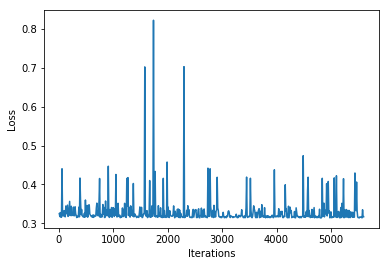

In [79]:
show_plot(counter,loss_history)

In [ ]:
torch.save(net.state_dict(), "model")

In [32]:
testset = LFWDataset(test=True,
                     transform=transforms.Compose([transforms.Scale((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

torch.Size([16, 3, 128, 128])


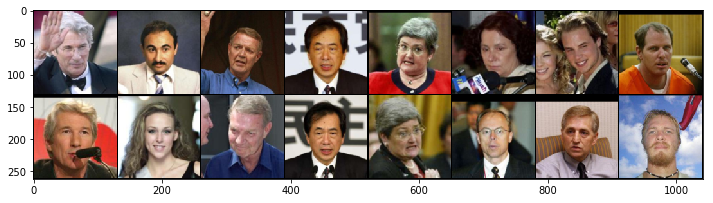


 1
 0
 1
 1
 1
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.2335  0.7665
 0.6365  0.3635
 0.3748  0.6252
 0.0989  0.9011
 0.8767  0.1233
 0.4264  0.5736
 0.5966  0.4034
 0.7635  0.2365
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(6, 2)
torch.Size([16, 3, 128, 128])


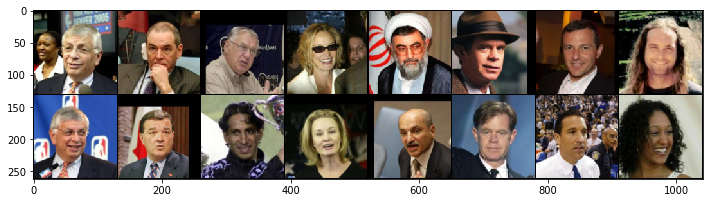


 1
 0
 0
 1
 0
 1
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.4108  0.5892
 0.1296  0.8704
 0.8713  0.1287
 0.2223  0.7777
 0.2687  0.7313
 0.8713  0.1287
 0.2177  0.7823
 0.8643  0.1357
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(10, 6)
torch.Size([16, 3, 128, 128])


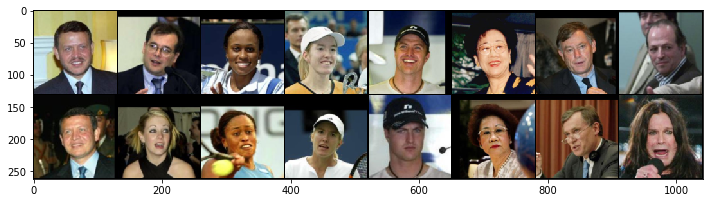


 1
 0
 1
 1
 1
 1
 1
 0
[torch.LongTensor of size 8]

Variable containing:
 0.3928  0.6072
 0.2234  0.7766
 0.7474  0.2526
 0.2207  0.7793
 0.9377  0.0623
 0.7998  0.2002
 0.2273  0.7727
 0.2429  0.7571
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(13, 11)
torch.Size([16, 3, 128, 128])


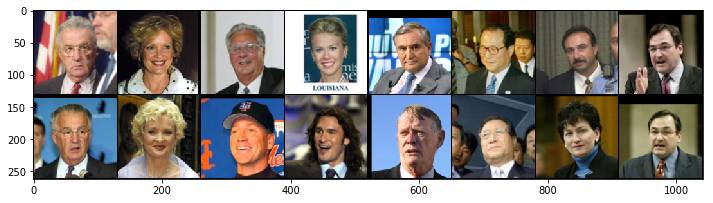


 1
 1
 0
 0
 0
 1
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 0.3355  0.6645
 0.5405  0.4595
 0.5479  0.4521
 0.3999  0.6001
 0.5842  0.4158
 0.9115  0.0885
 0.4479  0.5521
 0.1359  0.8641
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(17, 15)
torch.Size([16, 3, 128, 128])


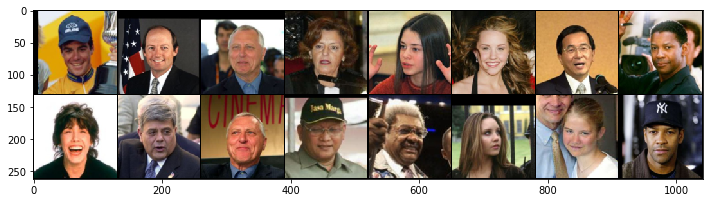


 0
 0
 1
 0
 0
 1
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 0.4685  0.5315
 0.6496  0.3504
 0.8330  0.1670
 0.4311  0.5689
 0.7080  0.2920
 0.5000  0.5000
 0.1490  0.8510
 0.2523  0.7477
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(20, 20)
torch.Size([16, 3, 128, 128])


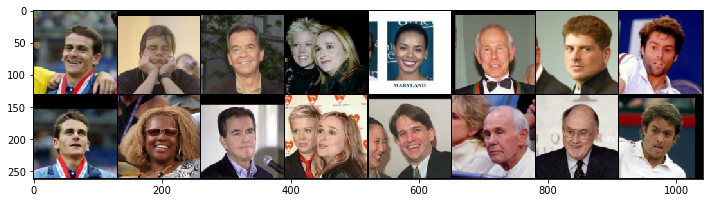


 1
 0
 1
 1
 0
 1
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 0.3815  0.6185
 0.4532  0.5468
 0.4427  0.5573
 0.7126  0.2874
 0.8841  0.1159
 0.8356  0.1644
 0.2010  0.7990
 0.0827  0.9173
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(24, 24)
torch.Size([16, 3, 128, 128])


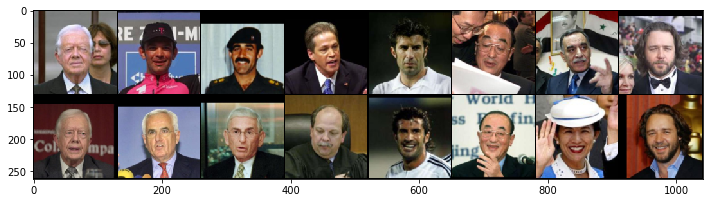


 1
 0
 0
 0
 1
 1
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 0.1708  0.8292
 0.2716  0.7284
 0.4313  0.5687
 0.3755  0.6245
 0.8013  0.1987
 0.4572  0.5428
 0.9275  0.0725
 0.3677  0.6323
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(28, 28)
torch.Size([16, 3, 128, 128])


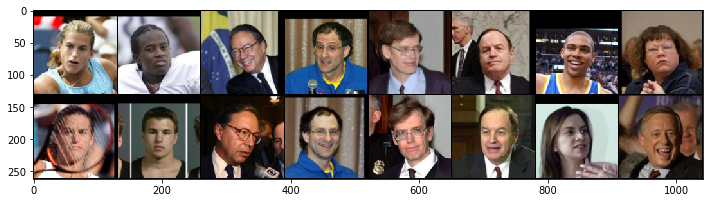


 1
 0
 1
 1
 1
 1
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.2672  0.7328
 0.7681  0.2319
 0.4235  0.5765
 0.8040  0.1960
 0.4093  0.5907
 0.2949  0.7051
 0.5068  0.4932
 0.4496  0.5504
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(34, 30)
torch.Size([16, 3, 128, 128])


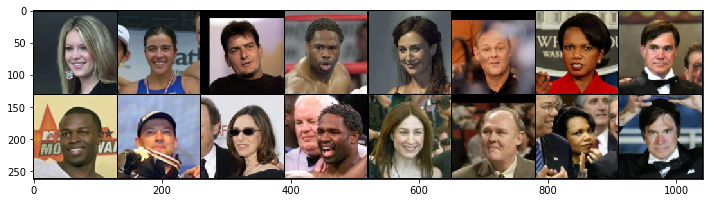


 0
 0
 0
 1
 1
 1
 1
 1
[torch.LongTensor of size 8]

Variable containing:
 0.2248  0.7752
 0.5489  0.4511
 0.7795  0.2205
 0.3153  0.6847
 0.3943  0.6057
 0.6434  0.3566
 0.6345  0.3655
 0.4304  0.5696
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(39, 33)
torch.Size([16, 3, 128, 128])


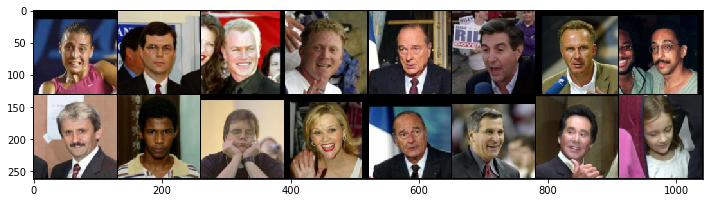


 0
 0
 0
 0
 1
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.4341  0.5659
 0.7523  0.2477
 0.8230  0.1770
 0.4488  0.5512
 0.0871  0.9129
 0.4488  0.5512
 0.6638  0.3362
 0.3956  0.6044
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(43, 37)
torch.Size([16, 3, 128, 128])


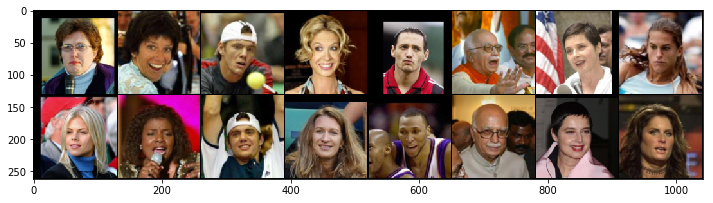


 0
 0
 1
 0
 0
 1
 1
 0
[torch.LongTensor of size 8]

Variable containing:
 0.6547  0.3453
 0.2829  0.7171
 0.7886  0.2114
 0.3039  0.6961
 0.5133  0.4867
 0.2257  0.7743
 0.2184  0.7816
 0.8942  0.1058
[torch.cuda.FloatTensor of size 8x2 (GPU 0)]

(48, 40)
(54, 42)
(59, 45)
(63, 49)
(67, 53)
(71, 57)
(78, 58)
(80, 64)
(84, 68)
(89, 71)
(95, 73)
(100, 76)
(106, 78)
(111, 81)
(115, 85)
(121, 87)
(125, 91)
(129, 95)
(134, 98)
(137, 103)
(140, 108)
(146, 110)
(153, 111)
(159, 113)
(166, 114)
(169, 119)
(174, 122)
(177, 127)
(179, 133)
(183, 137)
(187, 141)
(192, 144)
(196, 148)
(198, 154)
(201, 159)
(205, 163)
(210, 166)
(216, 168)
(219, 173)
(223, 177)
(230, 178)
(235, 181)
(237, 187)
(240, 192)
(246, 194)
(247, 201)
(251, 205)
(256, 208)
(259, 213)
(263, 217)
(266, 222)
(272, 224)
(277, 227)
(282, 230)
(285, 235)
(290, 238)
(296, 240)
(299, 245)
(306, 246)
(308, 252)
(314, 254)
(321, 255)
(323, 261)
(324, 268)
(326, 274)
(332, 276)
(337, 279)
(339, 285)
(343, 289)
(345, 295)
(348, 300)

In [59]:
right=wrong=0

for i, data in enumerate(testloader,0):
    img0, img1, label = data
    
    if i <= 10:
        concat = torch.cat((img0, img1), 0)
        print(concat.shape)
        grid = torchvision.utils.make_grid(concat)
        im = transforms.ToPILImage()(grid)
        plt.figure(figsize=(12,15))
        plt.imshow(im)
        plt.show()
#             im.save("output.png")
        print(label)
    
    img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
    
#     print(label)
    
    output = net(img0,img1)
    output = torch.cat((output, 1-output), 1)

    if i <=10:
        print(output)
        
    for x,y in zip(output[:,0], label):
#         print(x.data[0], y)
        if (x.data[0]<=0.5 and y.data[0]==1) or (x.data[0]>0.5 and y.data[0]==0):
            right+=1
        else:
            wrong+=1
            
    print(right, wrong)

In [58]:
print(right, wrong, right+wrong)

(537, 463, 1000)


In [84]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive